In [101]:
%autoreload

In [53]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import re
import pickle
import simple_notebookfns as sn

In [54]:
fname = "../exp/exp_duffing_1/Duffing_2023_10_17_20_51_57_954949_model.pkl"

with open(fname, 'rb') as f:
    params = pickle.load(f, encoding='latin1')

for key, val in params.items():
    print(key, val)

data_name Duffing
len_time 800
folder_name exp/exp_duffing_1
num_shifts 799
num_shifts_middle 799
recon_lam 0.001
L1_lam 0.0
auto_first 1
num_passes_per_file 4500
num_steps_per_batch 2
learning_rate 0.001
max_time 3600
min_5min 0.25
min_20min 0.02
min_40min 0.002
min_1hr 0.0002
min_2hr 2e-05
min_3hr 4e-06
min_4hr 5e-07
min_halfway 1
data_train_len 5
batch_size 256
num_steps_per_file_pass 6
L2_lam 1e-14
Linf_lam 1e-08
encoder_widths [2, 128, 256, 4]
encoder_act_type sigmoid
decoder_widths [4, 128, 256, 128, 2]
decoder_act_type linear
use_bias False
k_widths [4, 64, 128, 64, 4]
delta_t 1
exp_suffix _2023_10_17_20_51_57_954949
model_path ./exp/exp_duffing_1/Duffing_2023_10_17_20_51_57_954949_model.ckpt
seed 418498761
relative_loss 0
shifts [  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18
  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36
  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54
  55  56  57  58  59  60  61  62  

In [56]:
W, b = sn.load_weights_koopman(fname=fname, params=params)

print(W.keys())
print(b.keys())

dict_keys(['WE1', 'WE2', 'WE3', 'WD1', 'WD2', 'WD3', 'WD4', 'WK1', 'WK2', 'WK3', 'WK4'])
dict_keys(['bE1', 'bE2', 'bE3', 'bD1', 'bD2', 'bD3', 'bD4'])


In [57]:
for key, val in W.items():
    print(key, np.shape(val))

WE1 (2, 128)
WE2 (128, 256)
WE3 (256, 4)
WD1 (4, 128)
WD2 (128, 256)
WD3 (256, 128)
WD4 (128, 2)
WK1 (4, 64)
WK2 (64, 128)
WK3 (128, 64)
WK4 (64, 4)


In [91]:
model = sn.create_dummy_koopman_net(fname, params)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 encoder_1 (Dense)           (None, 128)               256       
                                                                 
 encoder_2 (Dense)           (None, 256)               32768     
                                                                 
 encoder_3 (Dense)           (None, 4)                 1024      
                                                                 
 k_1 (Dense)                 (None, 64)                256       
                                                                 
 k_2 (Dense)                 (None, 128)               8192      
                                                                 
 k_3 (Dense)                 (None, 64)                8192  

In [103]:
sn.set_koopman_net_weights(model, fname, params).summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 2)]               0         
                                                                 
 encoder_1 (Dense)           (None, 128)               256       
                                                                 
 encoder_2 (Dense)           (None, 256)               32768     
                                                                 
 encoder_3 (Dense)           (None, 4)                 1024      
                                                                 
 k_1 (Dense)                 (None, 64)                256       
                                                                 
 k_2 (Dense)                 (None, 128)               8192      
                                                                 
 k_3 (Dense)                 (None, 64)                8192  

In [104]:
model.predict([[1,1]])

1/1 [==============================] - 0s 35ms/step


array([[ 2.514781 , -1.4514384]], dtype=float32)

In [1]:
def f(t, x):
    delta = 0.5
    beta = -1
    alpha = 1
    return np.array([2 * x[1], -delta * 2 * x[1] - 2 * x[0] * (beta + alpha * (2 * x[0])**2)])

def f_u(t, x, u):
    return f(t, x) + np.expand_dims(np.array([u, 0]), 1)

n = 2
m = 1
deltaT = 0.01

def k1(t, x, u):
    return f_u(t, x, u)

def k2(t, x, u):
    return f_u(t, x + k1(t, x, u) * deltaT / 2, u)

def k3(t, x, u):
    return f_u(t, x + k2(t, x, u) * deltaT / 2, u)

def k4(t, x, u):
    return f_u(t, x + k1(t, x, u) * deltaT, u)

def f_ud(t, x, u):
    return x + (deltaT / 6) * (k1(t, x, u) + 2 * k2(t, x, u) + 2 * k3(t, x, u) + k4(t, x, u))


trajLen = 800
Ntraj = 1
Traj = []
#seed = 2141442
#np.random.seed(seed)
X_init =  np.array([0.5, 0.5])
for j in range(Ntraj):
    print(f'Collecting data without control: {j}/{Ntraj}')
    xx =  np.array([[0.5], [0.5]])#np.random.randn(n, 1)
    print(xx)
    traj = [xx]
    for i in range(trajLen - 1):
        xx = f_ud(0, xx, 0)
        traj.append(xx)
    Traj.append(np.hstack(traj))

X_DMD_test = np.hstack([traj[:, :-1] for traj in Traj])
Y_DMD_test = np.hstack([traj[:, 1:] for traj in Traj])

print(Y_DMD_test)

2023-10-22 19:48:08.519320: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-22 19:48:08.931433: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-10-22 19:48:08.931460: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-10-22 19:48:08.934240: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-22 19:48:09.177072: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-10-22 19:48:09.179238: I tensorflow/core/platform/cpu_feature_guard.cc:182] This Tens

[[0.5]
 [0.5]]
[[ 0.50994941  0.51979164  0.52951921 ...  0.50094094  0.50074213
   0.50054471]
 [ 0.49482162  0.48927708  0.48335103 ... -0.00997187 -0.00990621
  -0.00983328]]


In [21]:
# Define the FixWeights constraint function (replace this with your implementation)
class FixWeights(tf.keras.constraints.Constraint):
    def __call__(self, w):
        return w  # Placeholder; replace with your constraint logic

# Define the model architecture
tf.keras.backend.clear_session()
n_phi = 4

input_layer = tf.keras.Input(shape=(np.shape(X)[1],))
enc1 = tf.keras.layers.Dense(8, use_bias=False, activation='sigmoid')(input_layer)
enc2 = tf.keras.layers.Dense(n_phi, use_bias=False, activation='sigmoid')(enc1)

dyn_mod = tf.keras.layers.Dense(n_phi, use_bias=False, activation='linear')(enc2)

dec1 = tf.keras.layers.Dense(n_phi, use_bias=False, activation='linear', kernel_initializer="glorot_normal", kernel_constraint=FixWeights())(dyn_mod)
dec2 = tf.keras.layers.Dense(2, use_bias=False, activation='linear')(dec1)

output_layer = tf.keras.layers.Dense(2, use_bias=False, activation='linear')(dec2)

model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

# Manually set the weights
weights = [
    np.array([[-0.12764776, 0.09961356, 0.06462939, 0.56981283, -0.09261403, -0.05343678, -0.09697124, 0.24847567],
              [0.01128988, -0.02254958, -0.02707047, 0.007096, 0.02209817, -0.06549172, 0.02204219, -0.06510475]]),
    np.array([[0.49566275, 0.0256655, -0.25208613, -0.92109203],
              [-1.5812863, 1.7077931, 0.9524304, 1.7851063],
              [-0.9560983, 1.2800306, 1.9421403, 1.3798871],
              [0.251623, -1.0702709, -1.5502264, 0.10248603],
              [0.7935949, -0.47268653, -0.22448628, -0.14783786],
              [-0.20474236, -0.1607966, 0.41581354, -1.1426964],
              [1.0551684, -0.8199824, -0.546147, -0.79105926],
              [0.5348483, -0.5020152, -0.6257727, 0.22338976]]),
    np.array([[2.3408568, -1.4810318, -2.3390365, -1.4105294],
              [-0.64107496, 1.6626345, 1.4418739, 0.84002125],
              [0.43695474, 1.1069695, 1.0509763, -0.27855533],
              [-1.1000552, 0.96960497, -0.51086754, 1.0516015]]),
    np.array([[-1.9506483, 0.0, 0.0, 0.0],
              [0.0, 1.7394111, 0.0, 0.0],
              [0.0, 0.0, -2.4282606, 0.0],
              [0.0, 0.0, 0.0, -2.020012]]),
    np.array([[1.3486193, -2.7488391],
              [1.830916, -1.6395676],
              [-3.0127995, 0.8469842],
              [-0.9228591, 2.6111865]]),
    np.array([[-1.3022505, -1.9936004],
              [-1.430739, 1.4705862]])
]

model.set_weights(weights)



Predictions:
[[2.0378406  1.4506001 ]
 [2.0534623  0.77605253]
 [2.0570793  0.09302258]
 ...
 [0.53340894 0.13593724]
 [0.5348921  0.13573074]
 [0.5363732  0.13546517]]
[[ 0.5         0.5       ]
 [ 0.50994941  0.49482162]
 [ 0.51979164  0.48927708]
 ...
 [ 0.50114098 -0.01003014]
 [ 0.50094094 -0.00997187]
 [ 0.50074213 -0.00990621]]
25/25 [==============================] - 0s 2ms/step
[[0.5555969  0.5744138 ]
 [0.56603134 0.5694269 ]
 [0.57633626 0.56404096]
 ...
 [0.5459253  0.05435884]
 [0.54571533 0.05441099]
 [0.5455041  0.05447245]]


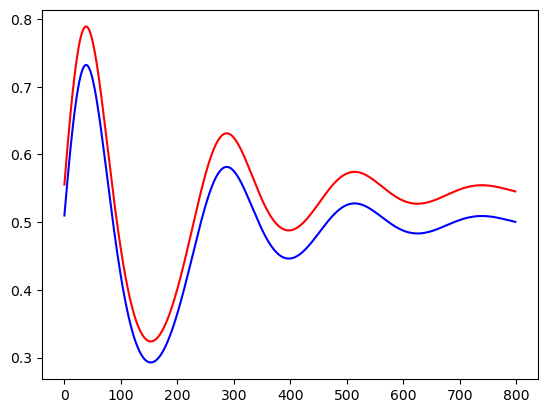

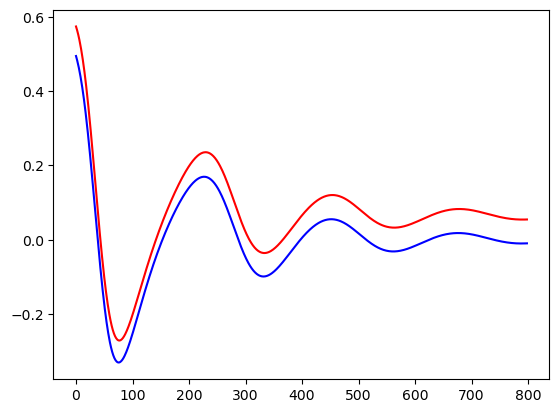

In [22]:
# Display the predictions
import matplotlib.pyplot as plt
print("Predictions:")
print(predictions)
print(X_DMD_test.T)
preds = model.predict(X_DMD_test.T)
print(preds)
plt.plot(Y_DMD_test.T[:,0], 'b')
plt.plot(preds[:,0], 'r')
plt.show()
plt.plot(Y_DMD_test.T[:,1], 'b')
plt.plot(preds[:,1], 'r')

In [24]:
#u = input_seq
print(X_init)
#model.predict(np.expand_dims(X_init, axis=0))
pred_model = []
time = 80
for i in range(time):
     if i == 0:
         pred = model.predict(np.expand_dims(X_init, axis=0))
         pred_model.append(pred)
         continue
     a = pred.tolist()[0]
     a = np.array(a)
     a = np.expand_dims(a, axis=0)
     pred = model.predict(a)
     pred_model.append(pred.tolist())

[0.5 0.5]
1/1 [==============================] - 0s 35ms/step


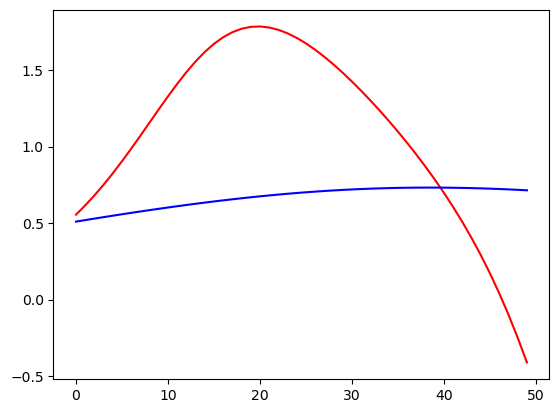

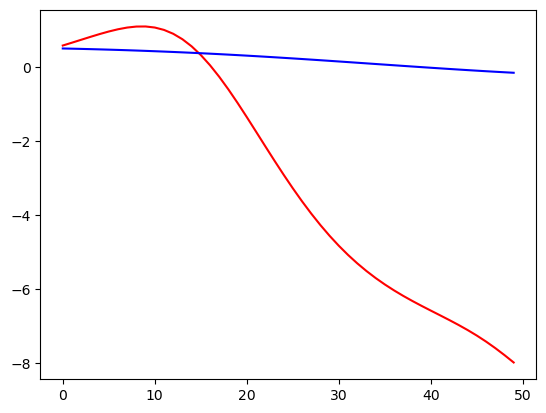

In [25]:
Y = Y_DMD_test.T
steps = 50

plt.plot(np.squeeze(np.array(pred_model))[0:steps, 0], 'r')
plt.plot(Y[0:steps, 0], 'b')
plt.show()
plt.plot(np.squeeze(np.array(pred_model))[0:steps, 1], 'r')
plt.plot(Y[0:steps, 1], 'b')

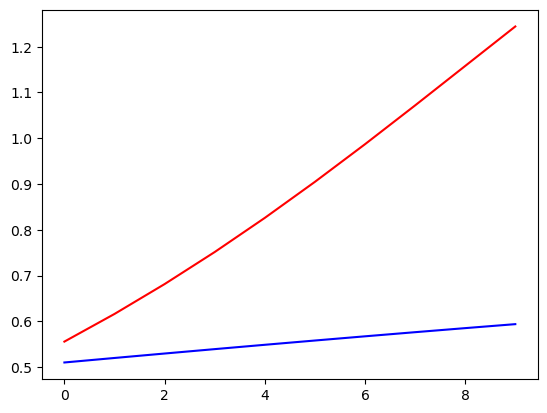

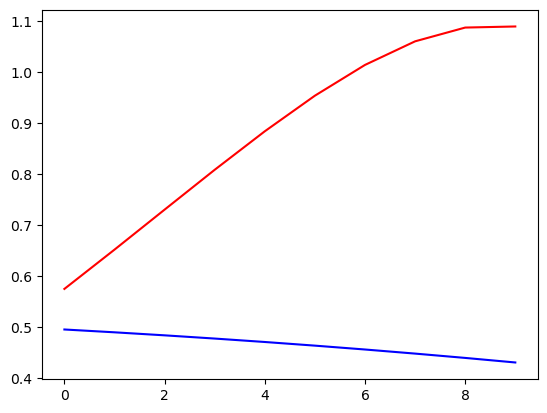

In [26]:
Y = Y_DMD_test.T
steps = 10

plt.plot(np.squeeze(np.array(pred_model))[0:steps, 0], 'r')
plt.plot(Y[0:steps, 0], 'b')
plt.show()
plt.plot(np.squeeze(np.array(pred_model))[0:steps, 1], 'r')
plt.plot(Y[0:steps, 1], 'b')

1/1 [==============================] - 0s 40ms/step


1/1 [==============================] - 0s 37ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 50ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 35ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 42ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 34ms/step


1/1 [==============================] - 0s 36ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 38ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 41ms/step


1/1 [==============================] - 0s 39ms/step


1/1 [==============================] - 0s 63ms/step


1/1 [==============================] - 0s 43ms/step


1/1 [==============================] - 0s 56ms/step


1/1 [==============================] - 0s 46ms/step


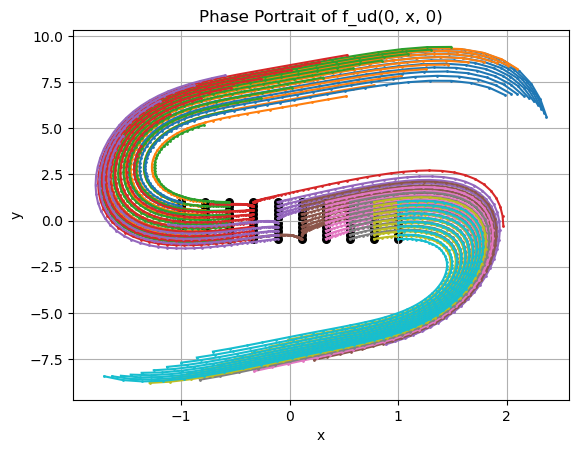

In [98]:
import numpy as np
import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')
# Create a grid of initial conditions
x_range = np.linspace(-1, 1, 10)  # Increase the number of initial conditions
y_range = np.linspace(-1, 1, 10)  # Increase the number of initial conditions

# Create a grid of combinations using meshgrid
X, Y = np.meshgrid(x_range, y_range)

# Stack the combinations as columns in a 2D array
initial = np.column_stack((X.ravel(), Y.ravel()))

# Initialize lists to store trajectories
x_trajectories = []
y_trajectories = []

# Fixed control input for the phase portrait
u = 0

# Define the number of time steps
time = 50  # You may adjust this based on your requirements

# Iterate through the grid of initial conditions
for i in range(initial.shape[0]):
    trajectory = [initial[i, :]]
    pred_model = []

    for t in range(time):
        pred = model.predict(np.array([trajectory[-1]]))  # Predict using the last point in the trajectory
        pred_model.append(pred[0])
        trajectory.append(pred[0])

    trajectory = np.array(trajectory)
    x_trajectories.append(trajectory[:, 0])
    y_trajectories.append(trajectory[:, 1])

# Plot the phase portrait
plt.figure()
for i in range(len(x_trajectories)):
    x = x_trajectories[i]
    y = y_trajectories[i]
    plt.plot(x, y, 'o-', markersize=1)
    # Round markers for the initial condition of each trajectory
    plt.scatter(x[0], y[0], c='black', marker='o', s=30)

plt.title('Phase Portrait of f_ud(0, x, 0)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()


1/1 [==============================] - 0s 47ms/step


1/1 [==============================] - 0s 50ms/step


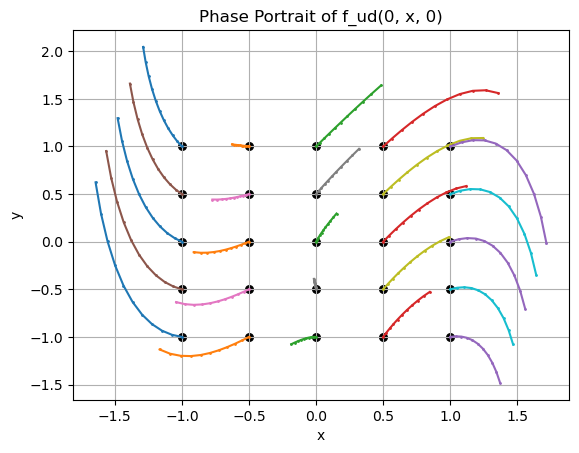

In [99]:
import numpy as np
import matplotlib.pyplot as plt
tf.get_logger().setLevel('ERROR')
# Create a grid of initial conditions
x_range = np.linspace(-1, 1, 5)  # Increase the number of initial conditions
y_range = np.linspace(-1, 1, 5)  # Increase the number of initial conditions

# Create a grid of combinations using meshgrid
X, Y = np.meshgrid(x_range, y_range)

# Stack the combinations as columns in a 2D array
initial = np.column_stack((X.ravel(), Y.ravel()))

# Initialize lists to store trajectories
x_trajectories = []
y_trajectories = []

# Fixed control input for the phase portrait
u = 0

# Define the number of time steps
time = 10  # You may adjust this based on your requirements

# Iterate through the grid of initial conditions
for i in range(initial.shape[0]):
    trajectory = [initial[i, :]]
    pred_model = []

    for t in range(time):
        pred = model.predict(np.array([trajectory[-1]]))  # Predict using the last point in the trajectory
        pred_model.append(pred[0])
        trajectory.append(pred[0])

    trajectory = np.array(trajectory)
    x_trajectories.append(trajectory[:, 0])
    y_trajectories.append(trajectory[:, 1])

# Plot the phase portrait
plt.figure()
for i in range(len(x_trajectories)):
    x = x_trajectories[i]
    y = y_trajectories[i]
    plt.plot(x, y, 'o-', markersize=1)
    # Round markers for the initial condition of each trajectory
    plt.scatter(x[0], y[0], c='black', marker='o', s=30)

plt.title('Phase Portrait of f_ud(0, x, 0)')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()


In [51]:

print(np.squeeze(np.array(pred_model))[0:10, 0])

[0.55559558 0.61600298 0.68127143 0.75133091 0.82595426 0.90471363
 0.98695499 1.07177448 1.15801525 1.24428272]
